In [1]:
from hand_written_text_recognition.src.data.evaluation import ocr_metrics
from hand_written_text_recognition.src.data.generator import DataGenerator
from hand_written_text_recognition.src.network.model import HTRModel
from rest.clients import groq_client 

In [2]:
from dotenv import load_dotenv
import os
load_dotenv()

GROQ_API_KEYS=os.getenv("GROQ_API_KEYS", "[]")
GROQ_API_KEYS = [key.removeprefix('"').removesuffix('"') for key in GROQ_API_KEYS.removeprefix('[').removesuffix(']').split(",")]

In [3]:
source_path="./data/mine_logs_v4.hdf5"
batch_size=16
charset_base="""0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ ČčĆćĐđŽžŠš"""
max_text_length=256
predict=True
architecture="flor"
input_size=(1024, 128, 1)
vocab_size=110
beam_width=30
reduce_tolerance=20
stop_tolerance=30
target_path="./ml_models/mine_logs_v4/flor/text_detection_model_v4.hdf5"

In [4]:
dtgen = DataGenerator(source=source_path,
                              batch_size=batch_size,
                              charset=charset_base,
                              max_text_length=max_text_length,
                              predict=True)

model = HTRModel(architecture=architecture,
                         input_size=input_size,
                         vocab_size=dtgen.tokenizer.vocab_size,
                         beam_width=30,
                         top_paths=10,
                         )


model.compile(learning_rate=0.001)
model.load_checkpoint(target=target_path)

In [ ]:

with open("./faulty_1.csv", "w", encoding="utf8") as t:
    for ds in ["valid"]:
        predicts, probability = model.predict(x=dtgen.next_valid_batch(),
                                    steps=dtgen.steps[ds],
                                    ctc_decode=True)

        predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
        ground_truth = [x.decode() for x in dtgen.dataset[ds]['gt']]

        for p, g in zip(predicts, ground_truth):
            if p.strip().upper() != g.strip().upper():
                t.write(f"{p.strip().upper()},{g.strip().upper()}\n")


In [ ]:
i = 0
rr = ""
with open("./faulty_1.csv", "r", encoding="utf8") as t:
    while r := t.readline():
        if i ==100:
            break
        p, q = r.split(",")
        rr += f"{p}{q}"
        i += 1

print(rr)


In [22]:
ds = "test"

predicts, probability = model.predict(x=dtgen.next_test_batch(),
                                steps=dtgen.steps[ds],
                                ctc_decode=True)
predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
ground_truth = [x.decode() for x in dtgen.dataset[ds]['gt']]
probability = [str(y[0]) for y in probability]

z = list(zip(predicts, ground_truth, probability))

with open("testtestetest.csv", "w", encoding="utf8") as w:
    for idx, l in enumerate(z):
        ll = [str(idx)]
        l = [i for i in l]
        l = ll + l
        w.write(f"{','.join(l)}\n")

In [13]:
import datetime
import asyncio

async def test(ds="test", groq_model: str = None, few_shot_size: int = 50, groq_threshold: float = 1.0):
    """
    ds: vals "test", "valid", "train"
    """
    start_time = datetime.datetime.now()

    predicts, probability = model.predict(x=dtgen.next_test_batch(),
                                steps=dtgen.steps[ds],
                                ctc_decode=True)
    predicts = [dtgen.tokenizer.decode(x[0]) for x in predicts]
    ground_truth = [x.decode() for x in dtgen.dataset[ds]['gt']]
    
    if groq_model:
        probability = [y[0] for y in probability]
        predicts = [el for el in list(zip(predicts,probability))]
        client = groq_client.GroqClient(groq_model, GROQ_API_KEYS, few_shot_size)
        predicts = [asyncio.create_task(client.correct_extraction(x[0])) if x[1] <= groq_threshold else x[0] for x in predicts]
        await asyncio.gather(*[x for x in predicts if not isinstance(x, str)])
        predicts = [x if isinstance(x, str) else x.result() for x in predicts]

    
    total_time = datetime.datetime.now() - start_time
    evaluate = ocr_metrics(predicts=predicts, ground_truth=ground_truth)

    e_corpus = "\n".join([
        f"Total test images:    {dtgen.size[ds]}",
        f"Total time:           {total_time}",
        f"Time per item:        {total_time / dtgen.size[ds]}\n",
        "Metrics:",
        f"Character Error Rate: {evaluate[0]:.8f}",
        f"Word Error Rate:      {evaluate[1]:.8f}",
        f"Sequence Error Rate:  {evaluate[2]:.8f}"
    ])
    print(e_corpus)
    with open("val_test_fin.csv", "a") as wf:
        wf.write(f"{datetime.datetime.now().isoformat()},{groq_model},{dtgen.size[ds]},{total_time},{total_time / dtgen.size[ds]},{evaluate[0]:.8f},{evaluate[1]:.8f},{evaluate[2]:.8f},{few_shot_size},{groq_threshold:.4f}\n")


In [6]:
import datetime
import asyncio

async def test2(groq_model: str = None, few_shot_size: int = 50, groq_threshold: float = 1.0):
    """
    ds: vals "test", "valid", "train"
    """
    ds = "test"
    data = []
    with open("testtestetest.csv", "r", encoding="utf8") as r:
        data = r.readlines()

    data = [d.removesuffix("\n").split(',') for d in data]
    data = [[int(d[0]), d[1], d[2],float(d[3])] for d in data]

    idxs, predicts, ground_truth, probability = list(zip(*data))

    start_time = datetime.datetime.now()

    rl = set()
    try:
        with open(f"testtesttest-{groq_model}.csv", "r", encoding="utf8") as r:
            a = r.readlines()
            a = [rr.split(",") for rr in a]
            rl = {int(rr[0]) for rr in a}
    except Exception as e:
        with open(f"testtesttest-{groq_model}.csv", "w", encoding="utf8") as w:
            pass


    if groq_model:
        #predicts = [el for el in list(zip(idxs, predicts, probability))]
        client = groq_client.GroqClient(groq_model, GROQ_API_KEYS, few_shot_size)
        with open(f"testtesttest-{groq_model}.csv", "a", encoding="utf8") as w:

            for i, p, gt, pp in data:
                if i in rl:
                    continue
                if pp <= groq_threshold:
                    p = await client.correct_extraction(p)
                
                w.write(f"{i},{p},{gt},{pp}\n")

    
    total_time = datetime.datetime.now() - start_time

    print(total_time)


# NO LLM

In [17]:
await test2()

Total test images:    167
Total time:           0:00:00
Time per item:        0:00:00

Metrics:
Character Error Rate: 0.15146988
Word Error Rate:      0.33092743
Sequence Error Rate:  0.49700599


In [119]:
await test()

Total test images:    167
Total time:           0:00:10.089143
Time per item:        0:00:00.060414

Metrics:
Character Error Rate: 0.15146988
Word Error Rate:      0.33092743
Sequence Error Rate:  0.49700599


# llama3-8b-8192

In [8]:
await test2(groq_model="llama3-8b-8192", groq_threshold=0.5)

0:03:48.978446


llama3-8b-8192
llama3-70b-8192
llama-3.1-70b-versatile
llama-3.1-8b-instant
gemma-7b-it
gemma2-9b-it
mixtral-8x7b-32768

In [ ]:
await test(groq_model="llama3-8b-8192", groq_threshold=0.5)

In [29]:
await test(groq_model="llama3-8b-8192")

CancelledError: 

# llama3-70b-8192

In [72]:
await test(groq_model="llama3-70b-8192", groq_threshold=0.5)

Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 13345, Requested 832. Please try again in 1m21.775s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Retrying after 82.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 14999, Requested 832. Please try again in 1m38.317s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Retrying after 99.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 14998, Requested 835. Please 

In [73]:
await test(groq_model="llama3-70b-8192")

Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 11711, Requested 829. Please try again in 1m5.403s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Retrying after 66.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 11710, Requested 833. Please try again in 1m5.435s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Retrying after 66.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 11710, Requested 832. Please tr

InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}

Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 11606, Requested 830. Please try again in 1m4.361s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Retrying after 65.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 48265, Requested 836. Please try again in 7m11.010999999s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}
Retrying after 432.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama3-70b-8192` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on tokens per minute (TPM): Limit 6000, Used 48116, Requested 830. P

# mixtral-8x7b-32768	

In [ ]:
await test(groq_model="mixtral-8x7b-32768", groq_threshold=0.5)

InternalServerError: Error code: 503 - {'error': {'message': 'Service Unavailable', 'type': 'internal_server_error'}}

In [ ]:
await test(groq_model="mixtral-8x7b-32768")

# gemma-7b-it

In [ ]:
await test(groq_model="gemma-7b-it", groq_threshold=0.5)

Total test images:    111
Total time:           0:06:28.377431
Time per item:        0:00:03.498896

Metrics:
Character Error Rate: 0.66371335
Word Error Rate:      0.70506803
Sequence Error Rate:  0.77477477


In [ ]:
await test(groq_model="gemma-7b-it")

Total test images:    111
Total time:           0:09:47.419875
Time per item:        0:00:05.292071

Metrics:
Character Error Rate: 0.96349016
Word Error Rate:      0.99043091
Sequence Error Rate:  1.00000000


# gemma2-9b-it

In [ ]:
await test(groq_model="gemma2-9b-it", groq_threshold=0.5)

Total test images:    111
Total time:           0:03:57.031107
Time per item:        0:00:02.135415

Metrics:
Character Error Rate: 0.19478908
Word Error Rate:      0.29265311
Sequence Error Rate:  0.77477477


In [ ]:
await test(groq_model="gemma2-9b-it")

Total test images:    111
Total time:           0:09:30.087623
Time per item:        0:00:05.135925

Metrics:
Character Error Rate: 0.24965632
Word Error Rate:      0.31797765
Sequence Error Rate:  1.00000000


# llama-3.1-405b-reasoning

In [ ]:
await test(groq_model="llama-3.1-405b-reasoning", groq_threshold=0.5)

In [ ]:
await test(groq_model="llama-3.1-405b-reasoning")

# llama-3.1-70b-versatile

In [ ]:
await test(groq_model="llama-3.1-70b-versatile", groq_threshold=0.5)

Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on : Limit 131072, Used 162609, Requested 840. Please try again in 5h55m42.794515625s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}
Retrying after 21343.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on : Limit 131072, Used 162609, Requested 834. Please try again in 5h55m38.8754375s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}
Retrying after 21339.0s
Exception  Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-70b-versatile` in organization `org_01j2xrw9v6et9bcnh7vxtt025v` on : Limit 131072, Used 162609, Requested 836. Please try again in 5h55m40.14279

: 

In [ ]:
await test(groq_model="llama-3.1-70b-versatile")

# Results:

In [1]:
data = []

with open("./ress.csv", "r") as rf:
    head = rf.readline()
    head = head.split(",")
    while line := rf.readline():
        line = line.split(",")
        data_zip = {k.removesuffix("\n"): v.removesuffix("\n") for k, v in list(zip(head, line))}
        data.append(data_zip)


In [4]:
d1 = [i for i in data if i["NAME"].startswith("05")]
d2 = [i for i in data if i["NAME"].startswith("1")]

In [9]:
#x_labels = [f'{i["MODEL_NAME"]}-{float(i["FEW_SHOT_SIZE"]):.2f}-{float(i["GROQ_THRESHOLD"]):2f}' for i in data]
x_labels = [f'{i["NAME"]}' for i in d2]
y_values_cer = [float(i["CER"]) for i in d2]
y_values_wer = [float(i["WER"]) for i in d2]
#y_values_ser = [float(i["SER"]) for i in data]

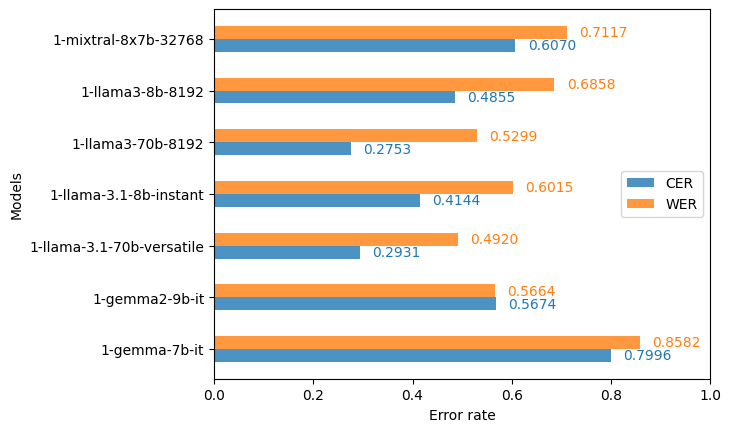

In [11]:
import matplotlib.pyplot as plt
import numpy as np

x_labels = x_labels
group1_values = y_values_cer
group2_values = y_values_wer
#group3_values = y_values_ser

colors_group1 = '#1f77b4'  # Blue
colors_group2 = '#ff7f0e'  # Orange
#colors_group3 = '#2ca02c'  # Green

fig, ax = plt.subplots()
n_groups = len(x_labels)
index = np.arange(n_groups)
bar_height = 0.25
opacity = 0.8

bars1 = ax.barh(index, group1_values, bar_height, alpha=opacity, color=[colors_group1], label='CER')
bars2 = ax.barh(index + bar_height, group2_values, bar_height, alpha=opacity, color=[colors_group2], label='WER')
#bars3 = ax.barh(index + 2*bar_height, group3_values, bar_height, alpha=opacity, color=[colors_group3], label='SER')

ax.set_ylabel('Models')
ax.set_xlabel('Error rate')
ax.set_yticks(index + bar_height / 2)
ax.set_yticklabels(x_labels, rotation=0)
ax.legend()

ax.set_xlim(0, 1.0)

for bar, label, value in zip(bars1, x_labels, group1_values):
    ax.text(bar.get_width() + 0.025, bar.get_y() + bar.get_height() / 2, f'{value:.4f}', 
            ha='left', va='center', color=colors_group1, rotation=0)
            
for bar, label, value in zip(bars2, x_labels, group2_values):
    ax.text(bar.get_width() + 0.025, bar.get_y() + bar.get_height() / 2, f'{value:.4f}', 
            ha='left', va='center', color=colors_group2, rotation=0)

"""
for bar, label, value in zip(bars3, x_labels, group3_values):
    ax.text(bar.get_width() + 0.025, bar.get_y() + bar.get_height() / 2, f'{value:.4f}', 
            ha='left', va='center', color=colors_group3, rotation=0)
"""
            
plt.show()


In [83]:
a = "./MINSKI_ZAPISNICI_IMENOVANI_REGIJE_DOKUMENTI/REGIJA_5_PASCALVOC_LABELE"
b = "./MINSKI_ZAPISNICI_IMENOVANI_REGIJE_DOKUMENTI/REGIJA_0_PASCALVOC_LABELE"

import os


aa = len(list(os.listdir(a)))
bb = len(list(os.listdir(b)))

print(f"""
{aa}
{bb}
""")



559
304

